## Imports


In [103]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#MLFLOW
import mlflow
mlflow.autolog()

2023/11/24 16:43:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/11/24 16:43:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/11/24 16:43:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


## Données  


In [104]:
# List files available
print(os.listdir("raw_data"))

['application_train.csv']


In [105]:
# Training data
app_train = pd.read_csv('raw_data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [106]:
app_train = app_train.sample(frac =.20)
app_train.shape

(61502, 122)

In [107]:
labels = app_train['TARGET']

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(app_train, labels, shuffle=True, train_size=0.8, random_state=42)
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_temp de forme {X_temp.shape} et y_temp de forme {y_temp.shape}")

Nous avons X_train de forme (49201, 122) et y_train de forme (49201,)
Nous avons X_temp de forme (12301, 122) et y_temp de forme (12301,)


In [109]:
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, shuffle=False, test_size=0.5, random_state=42) #ici
#on ne touchera pas a la partie validation du dataset, seulement à la toute fin
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
X_valid = X_valid.drop(X_valid.index[[0]])
y_valid = y_valid.drop(X_valid.index[[0]])
print(f"Nous avons X_valid de forme {X_valid.shape} et y_valid de forme {y_valid.shape}")

Nous avons X_test de forme (6150, 122) et y_test de forme (6150,)
Nous avons X_valid de forme (6150, 122) et y_valid de forme (6150,)


# Exploratory Data Analysis

## Distribution Target

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [110]:
y_train.value_counts()

TARGET
0    45324
1     3877
Name: count, dtype: int64

In [111]:
from numpy import bincount

49201 / 3922

12.544875063742989

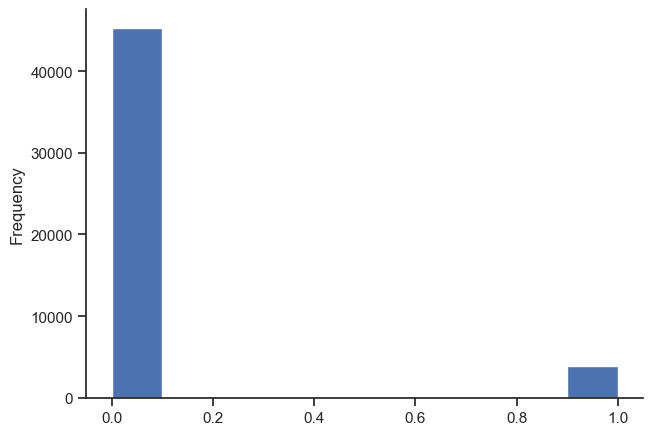

In [112]:
y_train.astype(int).plot.hist();

## NaN

<Axes: >

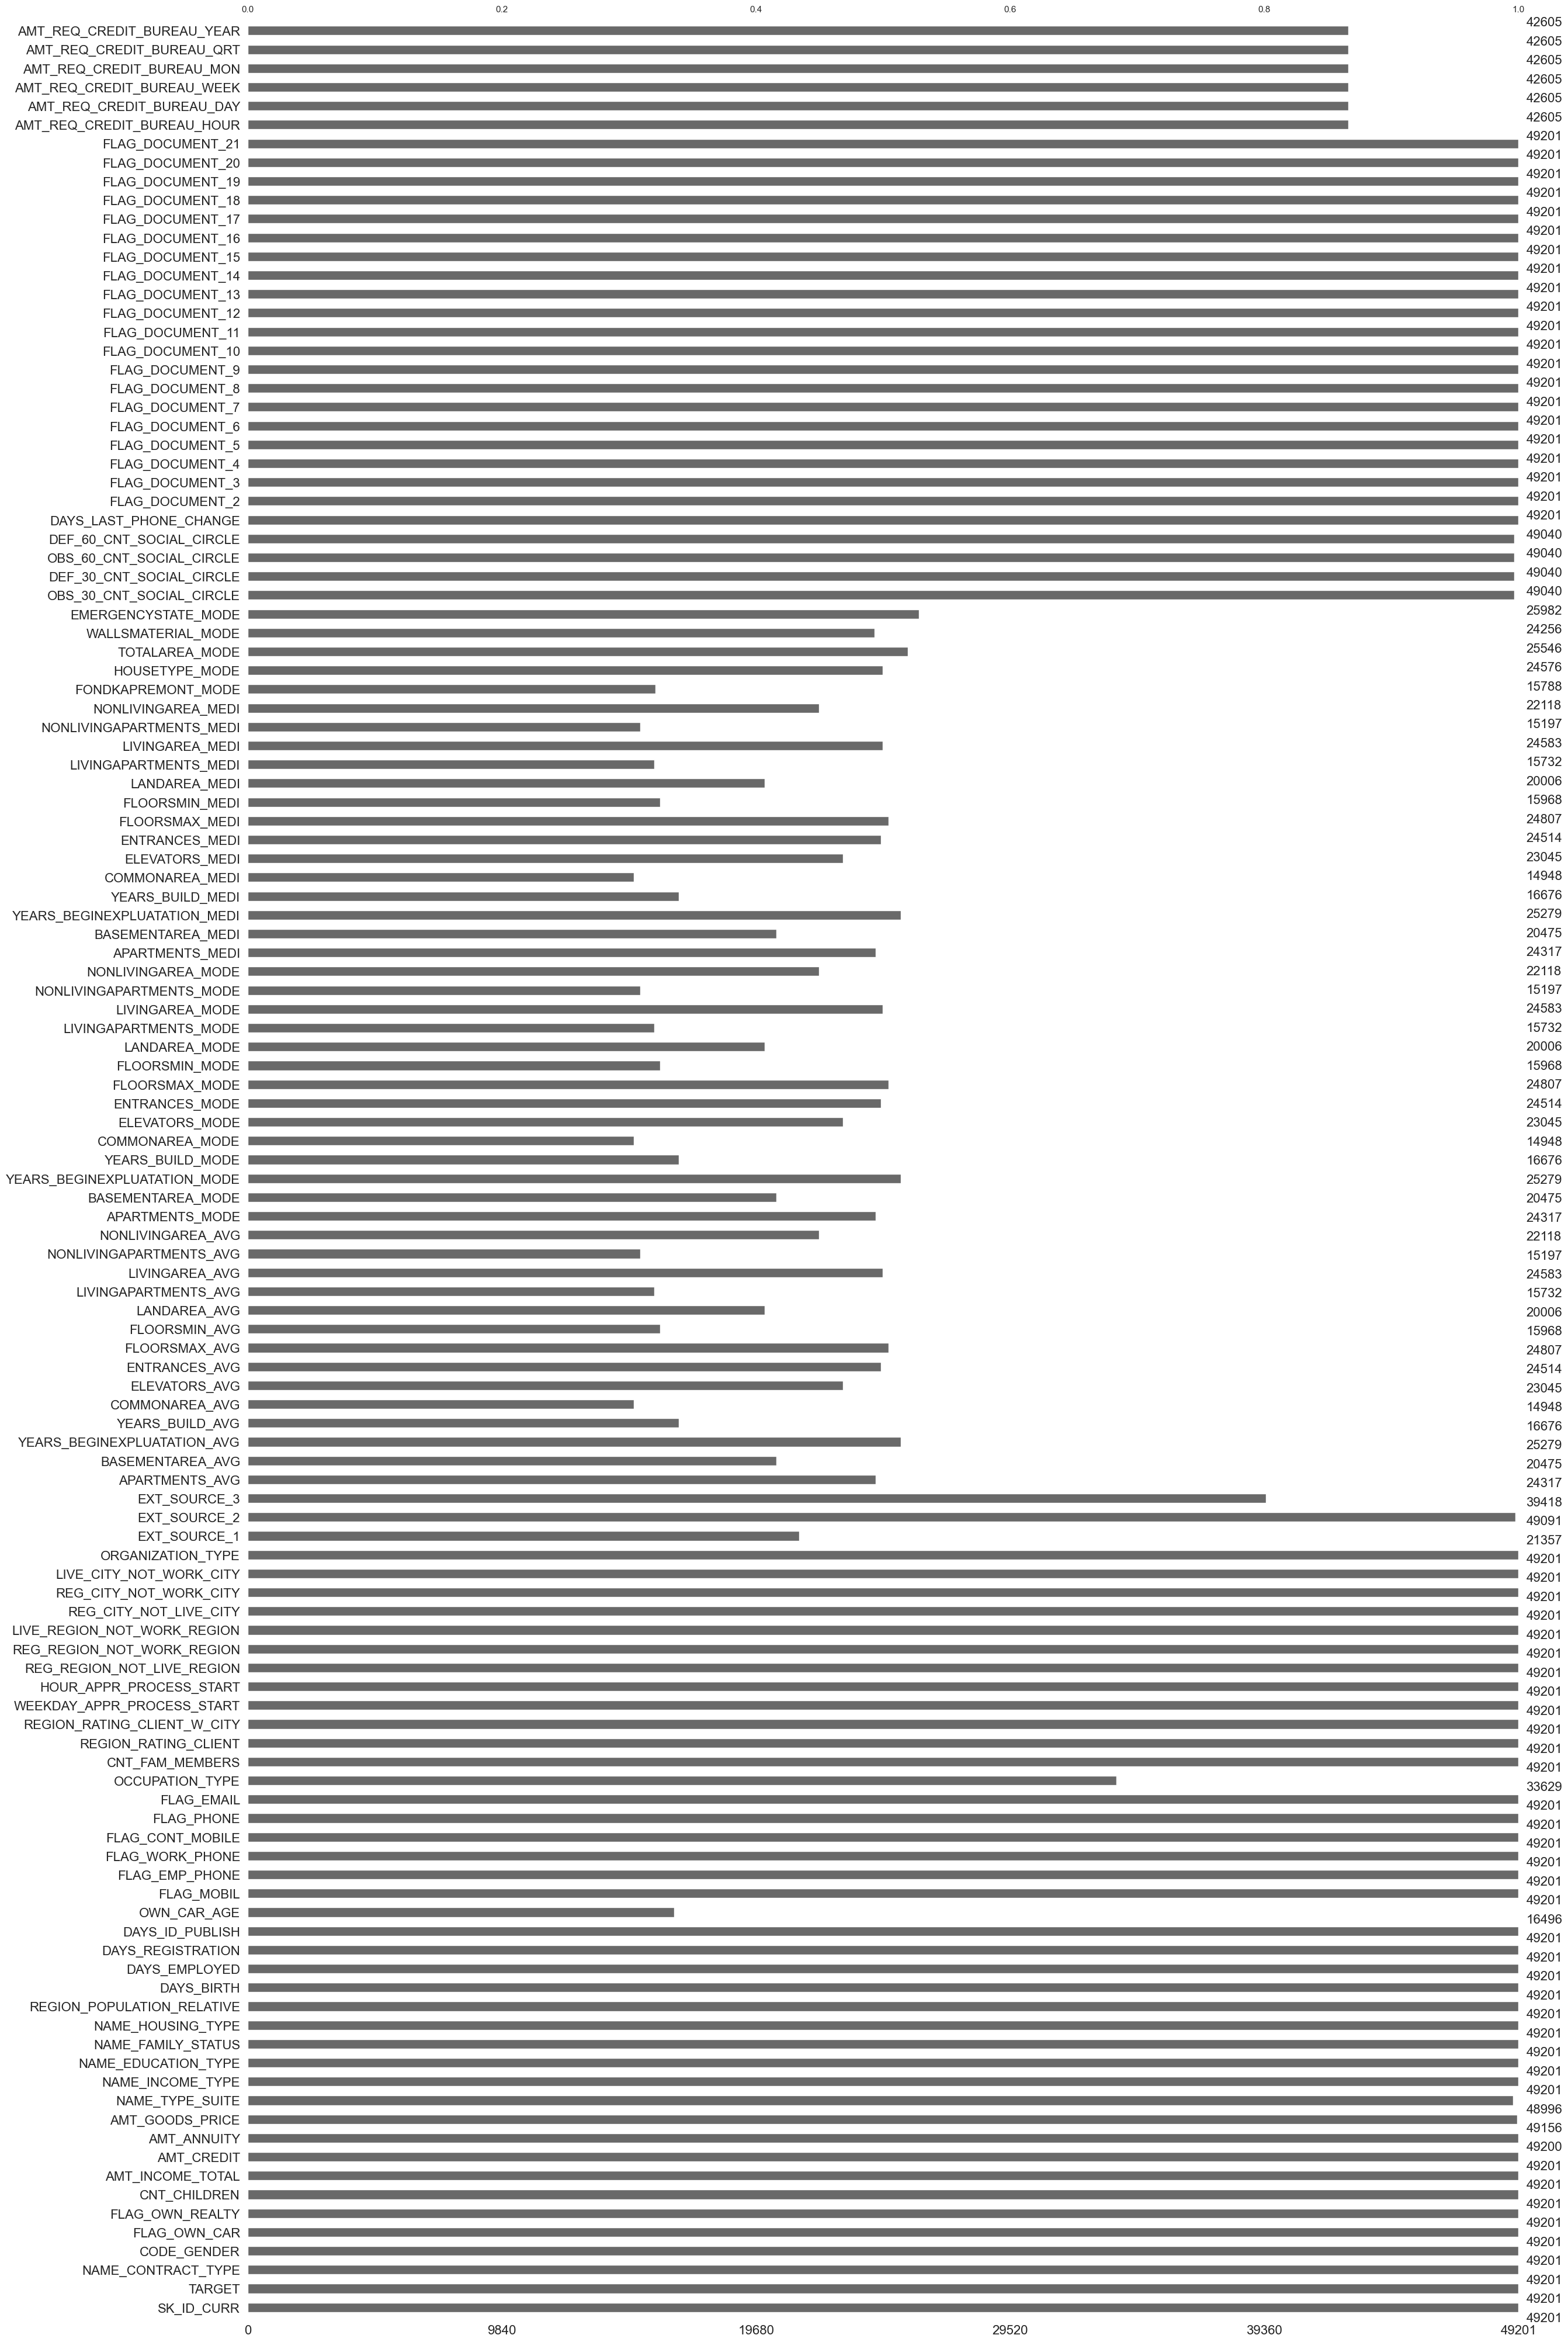

In [113]:
import missingno as msn
msn.bar(X_train)

## Column Types

In [114]:
# Number of each type of column
X_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [115]:
# Number of unique classes in each object column
X_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [116]:
print(X_train['DAYS_EMPLOYED'].describe(),
X_test['DAYS_EMPLOYED'].describe(),
X_valid['DAYS_EMPLOYED'].describe())

count     49201.000000
mean      63911.587285
std      141370.874352
min      -17583.000000
25%       -2777.000000
50%       -1212.000000
75%        -285.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64 count      6150.000000
mean      65161.236585
std      142400.806238
min      -16836.000000
25%       -2734.750000
50%       -1184.500000
75%        -274.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64 count      6150.000000
mean      61604.285528
std      139380.075179
min      -16499.000000
25%       -2766.000000
50%       -1221.000000
75%        -304.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


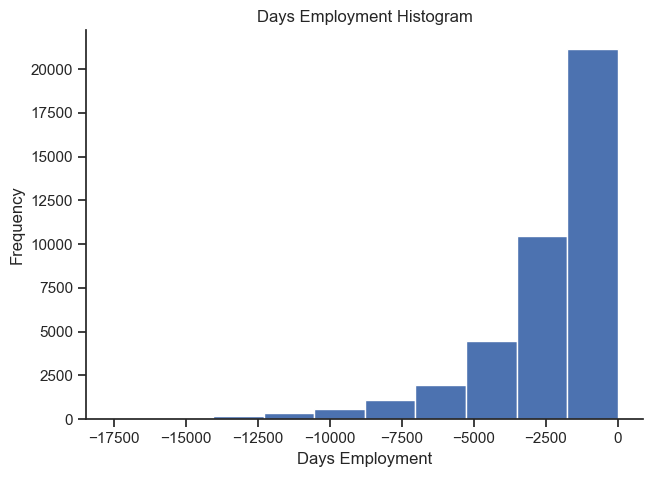

In [117]:
# Create an anomalous flag column
X_train['DAYS_EMPLOYED_ANOM'] = X_train["DAYS_EMPLOYED"] == 365243
X_test['DAYS_EMPLOYED_ANOM'] = X_test["DAYS_EMPLOYED"] == 365243
X_valid['DAYS_EMPLOYED_ANOM'] = X_valid["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
X_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
X_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
X_valid["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

X_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [118]:
(X_train['DAYS_BIRTH'] / -365).describe()
(X_test['DAYS_BIRTH'] / -365).describe()
(X_valid['DAYS_BIRTH'] / -365).describe()

count    6150.000000
mean       43.760810
std        11.968169
min        21.076712
25%        33.799315
50%        42.954795
75%        53.683562
max        68.838356
Name: DAYS_BIRTH, dtype: float64

In [119]:
# Find the correlation of the positive days since birth and target
X_train['DAYS_BIRTH'] = abs(X_train['DAYS_BIRTH'])
X_train['DAYS_BIRTH'].corr(X_train['TARGET'])

-0.08148418220348863

### Effect of Age on Repayment

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

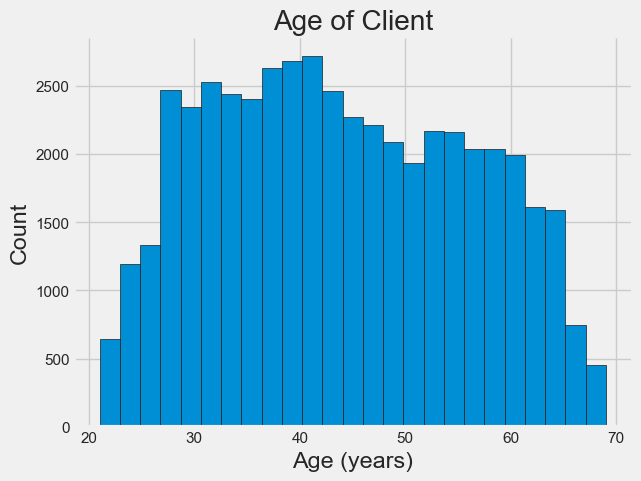

In [120]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(X_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

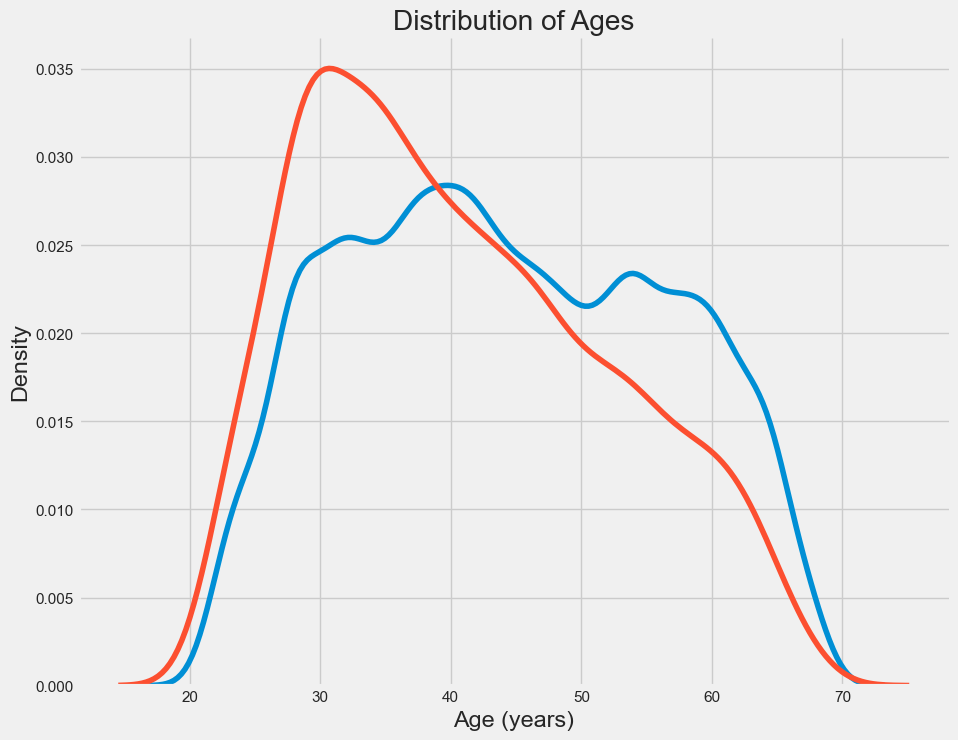

In [121]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [122]:
# Age information into a separate dataframe
age_data = X_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
72398,0,15575,42.671233,"(40.0, 45.0]"
53000,0,18896,51.769863,"(50.0, 55.0]"
252420,0,13161,36.057534,"(35.0, 40.0]"
96448,0,13302,36.443836,"(35.0, 40.0]"
55407,1,9558,26.186301,"(25.0, 30.0]"
32839,0,15863,43.460274,"(40.0, 45.0]"
196751,0,11218,30.734247,"(30.0, 35.0]"
73396,0,11547,31.635616,"(30.0, 35.0]"
220577,0,19255,52.753425,"(50.0, 55.0]"
62331,0,21870,59.917808,"(55.0, 60.0]"


In [123]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.120851,8532.981846,23.378032
"(25.0, 30.0]",0.110083,10155.709215,27.823861
"(30.0, 35.0]",0.106470,11860.997016,32.495882
"(35.0, 40.0]",0.084581,13708.142584,37.556555
"(40.0, 45.0]",0.074108,15484.982688,42.424610
"(45.0, 50.0]",0.074219,17315.311435,47.439209
"(50.0, 55.0]",0.064627,19199.400797,52.601098
"(55.0, 60.0]",0.052042,20993.173789,57.515545
"(60.0, 65.0]",0.050448,22773.500673,62.393153


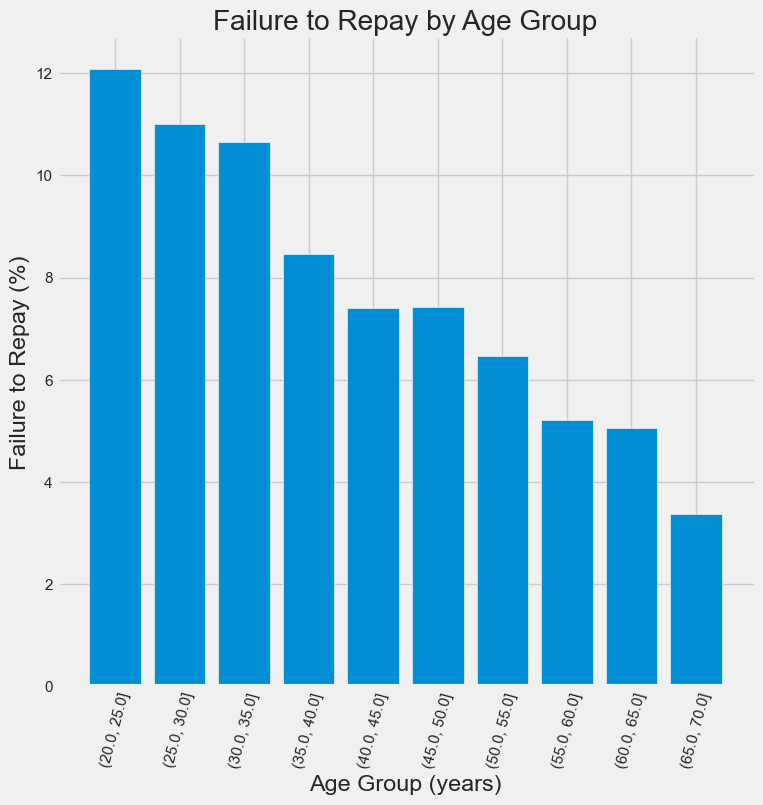

In [124]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [125]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = X_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.150485,-0.158575,-0.177922,-0.081484
EXT_SOURCE_1,-0.150485,1.000000,0.208779,0.181124,0.598771
EXT_SOURCE_2,-0.158575,0.208779,1.000000,0.110012,0.097770
EXT_SOURCE_3,-0.177922,0.181124,0.110012,1.000000,0.201069
DAYS_BIRTH,-0.081484,0.598771,0.097770,0.201069,1.000000


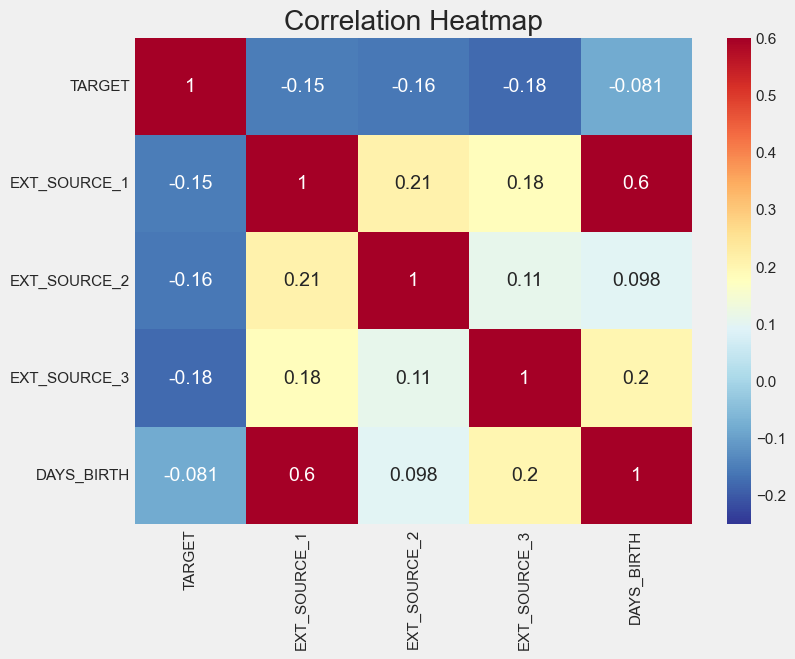

In [126]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

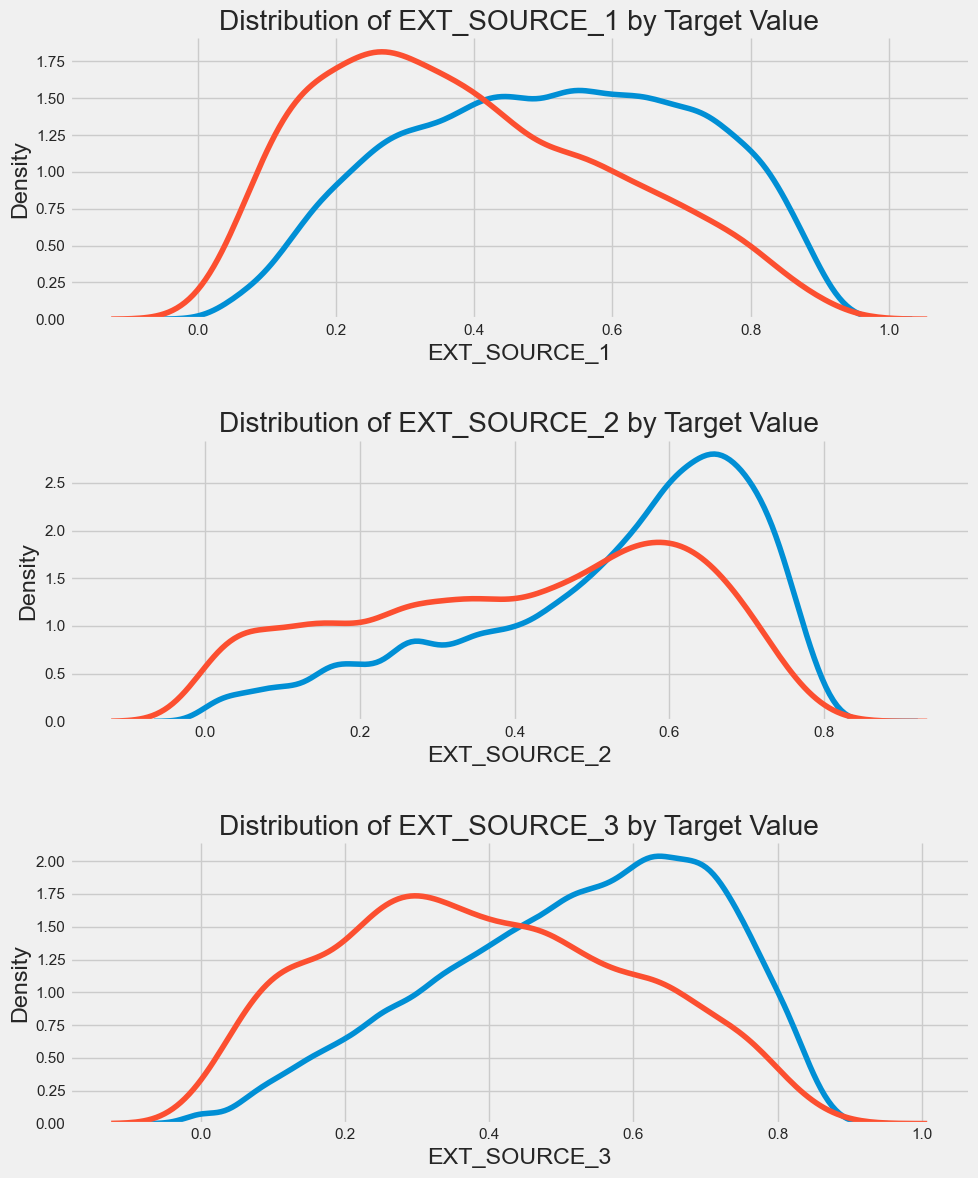

In [127]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

# Feature Engineering


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [128]:
X_train['CREDIT_INCOME_PERCENT'] = X_train['AMT_CREDIT'] / X_train['AMT_INCOME_TOTAL']
X_train['ANNUITY_INCOME_PERCENT'] = X_train['AMT_ANNUITY'] / X_train['AMT_INCOME_TOTAL']
X_train['CREDIT_TERM'] = X_train['AMT_ANNUITY'] / X_train['AMT_CREDIT']
X_train['DAYS_EMPLOYED_PERCENT'] = X_train['DAYS_EMPLOYED'] / X_train['DAYS_BIRTH']

In [129]:
X_test['CREDIT_INCOME_PERCENT'] = X_test['AMT_CREDIT'] / X_test['AMT_INCOME_TOTAL']
X_test['ANNUITY_INCOME_PERCENT'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']
X_test['CREDIT_TERM'] = X_test['AMT_ANNUITY'] / X_test['AMT_CREDIT']
X_test['DAYS_EMPLOYED_PERCENT'] = X_test['DAYS_EMPLOYED'] / X_test['DAYS_BIRTH']

In [130]:
X_valid['CREDIT_INCOME_PERCENT'] = X_valid['AMT_CREDIT'] / X_valid['AMT_INCOME_TOTAL']
X_valid['ANNUITY_INCOME_PERCENT'] = X_valid['AMT_ANNUITY'] / X_valid['AMT_INCOME_TOTAL']
X_valid['CREDIT_TERM'] = X_valid['AMT_ANNUITY'] / X_valid['AMT_CREDIT']
X_valid['DAYS_EMPLOYED_PERCENT'] = X_valid['DAYS_EMPLOYED'] / X_valid['DAYS_BIRTH']

In [131]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(49201, 127)
(6150, 127)
(6150, 127)


#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out! 

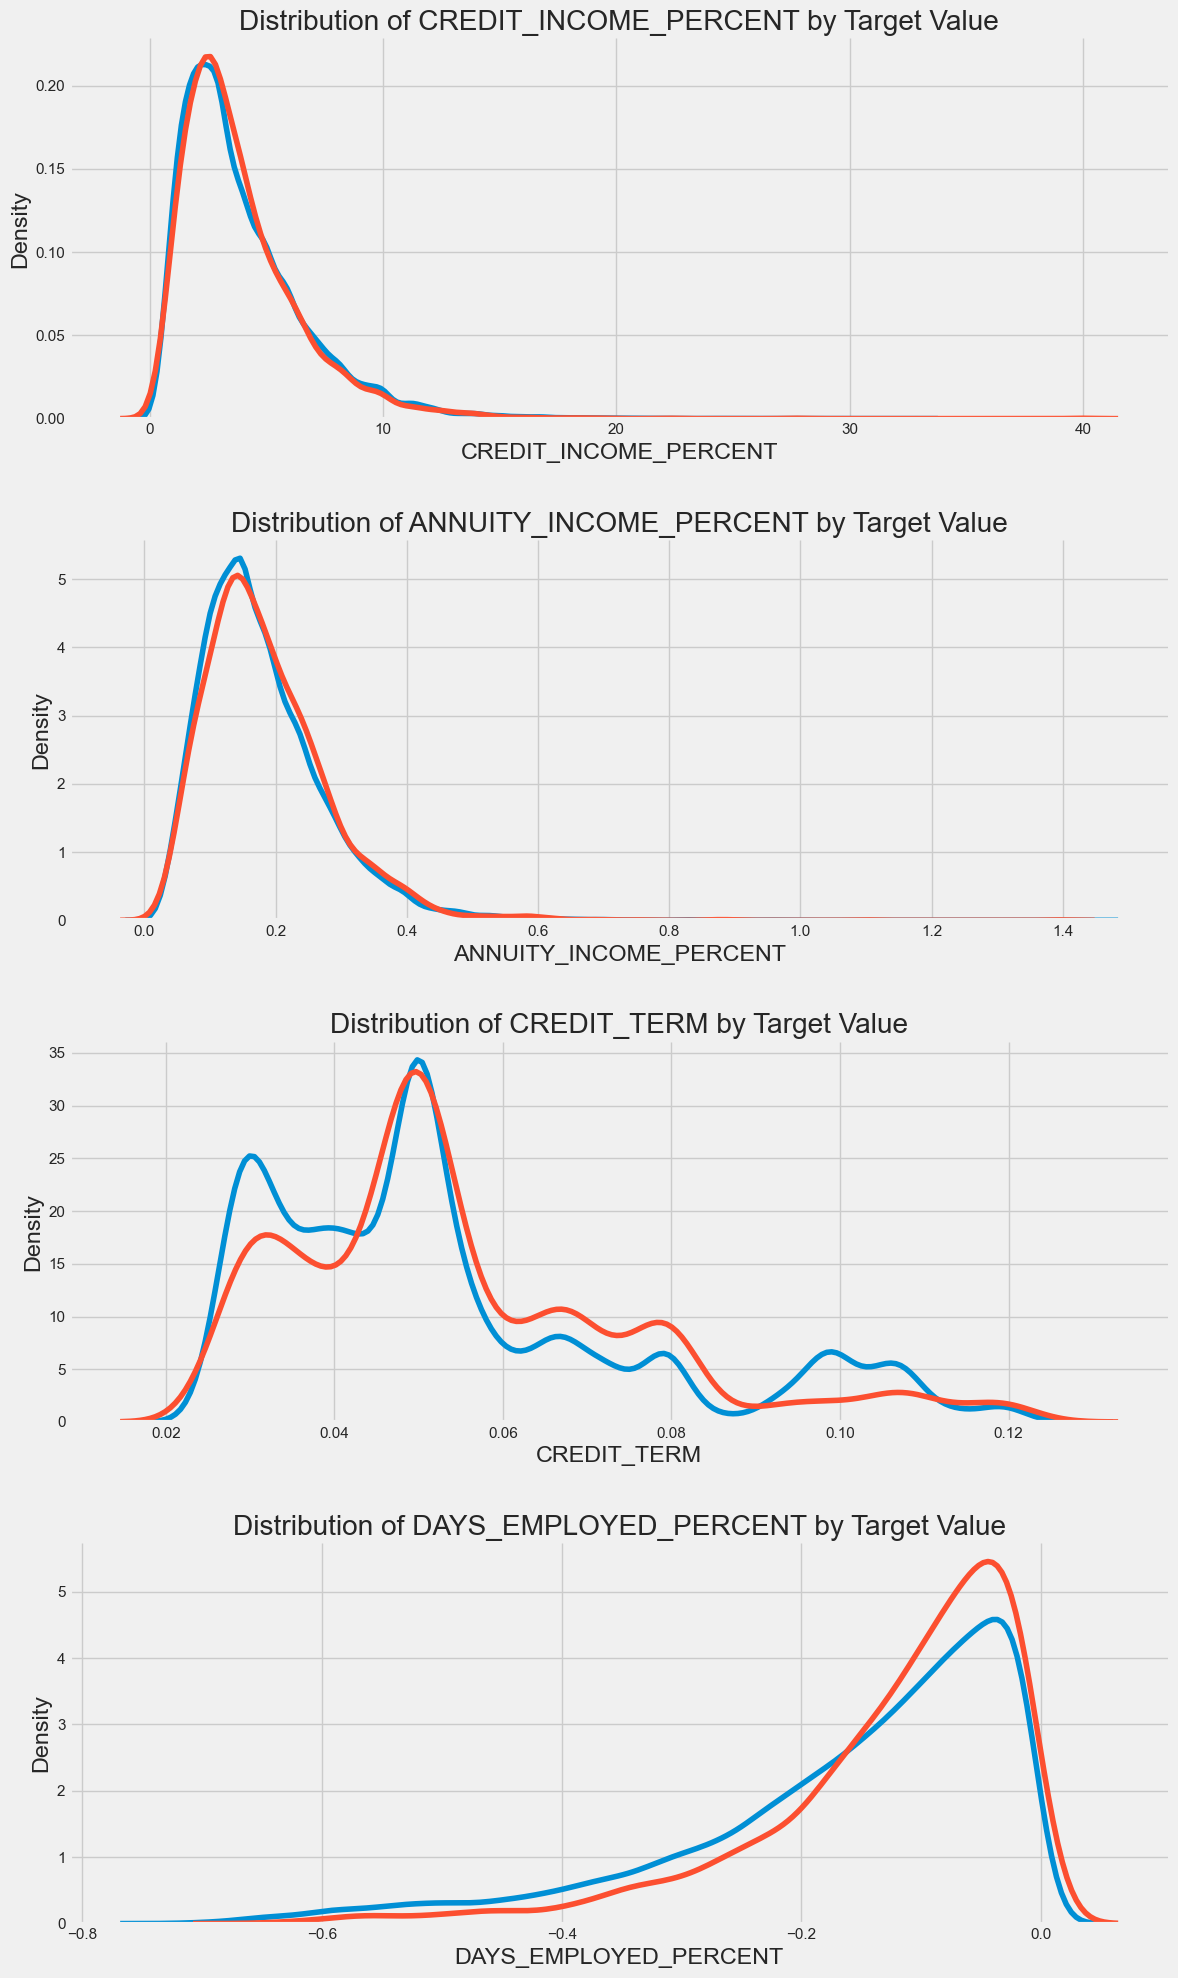

In [132]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

In [133]:
target_name = "TARGET"
y_train = X_train[target_name]

In [134]:
X_train_evidently = X_train.copy()
X_test_evidently = X_test.copy()
X_valid_evidently = X_valid.copy()

y_train_evidently = y_train.copy()
y_test_evidently = y_test.copy()
y_valid_evidently = y_valid.copy()

In [135]:
X_train = X_train.drop(columns=['TARGET', 'SK_ID_CURR'])
X_test = X_test.drop(columns=['TARGET', 'SK_ID_CURR'])
X_valid = X_valid.drop(columns=['TARGET', 'SK_ID_CURR'])

In [136]:
X_train['DAYS_EMPLOYED_ANOM'] = X_train.select_dtypes(include='bool').astype('uint8')
X_test['DAYS_EMPLOYED_ANOM'] = X_test.select_dtypes(include='bool').astype('uint8')
X_valid['DAYS_EMPLOYED_ANOM'] = X_valid.select_dtypes(include='bool').astype('uint8')
X_train.dtypes.value_counts()

float64    70
int64      38
object     16
uint8       1
Name: count, dtype: int64

In [137]:
numerical_features = X_train.select_dtypes(exclude="object").columns
categorical_features = X_train.select_dtypes(include='object').columns
print(X_train.shape)
print(numerical_features.shape)
print(categorical_features.shape)

(49201, 125)
(109,)
(16,)


In [138]:
features_X_train = X_train.columns
features_X_test = X_test.columns
features_X_valid = X_valid.columns

# Création du pipeline

In [139]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
import xgboost 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn import set_config

#class_weight={0:1, 1:12}
# Define the encoding strategy for features
numerical_features = X_train.select_dtypes(exclude="object").columns
n_unique_categories = X_train[categorical_features].nunique().sort_values(ascending=False)
high_cardinality_features = n_unique_categories[n_unique_categories > 15].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 15].index

set_config(transform_output="pandas")

# Define the preprocessing steps for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

# Define the preprocessing steps for categorical features
high_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('targ', TargetEncoder()),
    ('scaler', MinMaxScaler())])

# Define the preprocessing steps for categorical features
low_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('high_cat', high_categorical_transformer, high_cardinality_features),
        ('low_cat', low_categorical_transformer, low_cardinality_features)])


In [140]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# define pipeline
steps1 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', LogisticRegression(random_state=1))]
LogisticRegression = Pipeline(steps=steps1)

steps2 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', DummyClassifier(random_state=1))]
DummyClassifier = Pipeline(steps=steps2)

steps3 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', RandomForestClassifier(random_state=1))]
RandomForest = Pipeline(steps=steps3)

steps4 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model',  GradientBoostingClassifier(random_state=1))]
GradientBoosting = Pipeline(steps=steps4)

steps5 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', XGBClassifier(random_state=1))]
XGBClass = Pipeline(steps=steps5)

# Premier entrainement de modèles

In [141]:
# Création d'une métrique adaptée Fbeta score pour le GridSearchCV https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer

def bank_metric(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=10)

In [ ]:
# # option 1: simple "hack"
# def bank_metric(y_pred, y_true):
#     score = ...
#     mlflow.log_metric('bank_metric', score)
#     return score

In [142]:
bank_score = make_scorer(bank_metric, greater_is_better=True)

In [143]:
dict_of_models = {"LogisticRegression": LogisticRegression, 
                  "DummyClassifier" : DummyClassifier, 
                  "RandomForest" : RandomForest,
                  "GradientBoosting" : GradientBoosting,
                  "XGBClass" : XGBClass}

In [144]:
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")

In [145]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import cross_val_score
from time import time
from mlflow import MlflowClient
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from mlflow import log_param, log_metrics, set_tag
from mlflow.sklearn import log_model
from mlflow.models import infer_signature
warnings.filterwarnings("ignore")

def evaluation(model):
        
        with mlflow.start_run() as run:
           
            start_fit = time()
            model.fit(X_train, y_train)
            end_fit = time()
            start_predict_train = time()
            y_pred_train = model.predict(X_train)
            y_proba_train = model.predict_proba(X_train)[:, 1]
            end_predict_train = time()
            start_predict_test = time()
            y_pred_test = model.predict(X_test)
            y_proba_test = model.predict_proba(X_test)[:, 1]
            end_predict_test = time()
        
            bank_metric_train = bank_metric(y_train, y_pred_train)
            bank_metric_test = bank_metric(y_test, y_pred_test)
            roc_auc_score_train = roc_auc_score(y_train, y_proba_train)
            roc_auc_score_test = roc_auc_score(y_test, y_proba_test)
            fit_time = end_fit - start_fit
            predict_time_train = end_predict_train - start_predict_train
            predict_time_test = end_predict_test - start_predict_test
            roc_curve_train = roc_curve(y_train, y_pred_train)
            roc_curve_test = roc_curve(y_test, y_pred_test)
        
            print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
            mlflow.end_run()
        
        df_result = pd.DataFrame({
        "data" : ["train", "test"],
        "bank_metric" : [bank_metric_train, bank_metric_test],
        "AUC" : [roc_auc_score(y_train, y_proba_train), roc_auc_score(y_test, y_proba_test)],
        "fit_time" : [fit_time, fit_time],
        "predict_time" : [predict_time_train, predict_time_test]})
        
        metric = ['bank_metric','AUC', 'fit_time', 'predict_time']
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)
        fig = plt.figure(figsize=(20,60))

        for i, c in enumerate(metric,1):
            ax = fig.add_subplot(2,4,i)
            sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set3")
            plt.xticks(fontsize= 20)
            plt.yticks(fontsize= 14)
            plt.xlabel("", fontsize= 20)
            plt.ylabel(c, fontsize= 20)

        plt.tight_layout(w_pad=2, h_pad=1)
        plt.gcf().set_size_inches(16,7)
        plt.show()        
    
        return df_result

LogisticRegression


2023/11/24 16:44:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:44:06 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:44:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:44:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 52f2bd6b498d4ef6912cab3fe3885ae8. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 52f2bd6b498d4ef6912cab3fe3885ae8
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'C': '1.0', 'class_weight': 'None', 'dual': 'False', 'fit_intercept': 'True', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'intercept_scaling': '1', 'l1_ratio': 'None', 'leaf_size': '30', 'max_iter': '100', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'multi_class': 'auto', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'penalty': 'l2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 'scaler__copy': 'True', 'scaler__feature_range': '(0, 1)', 'solver': 'lbfgs', 'steps': "[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler

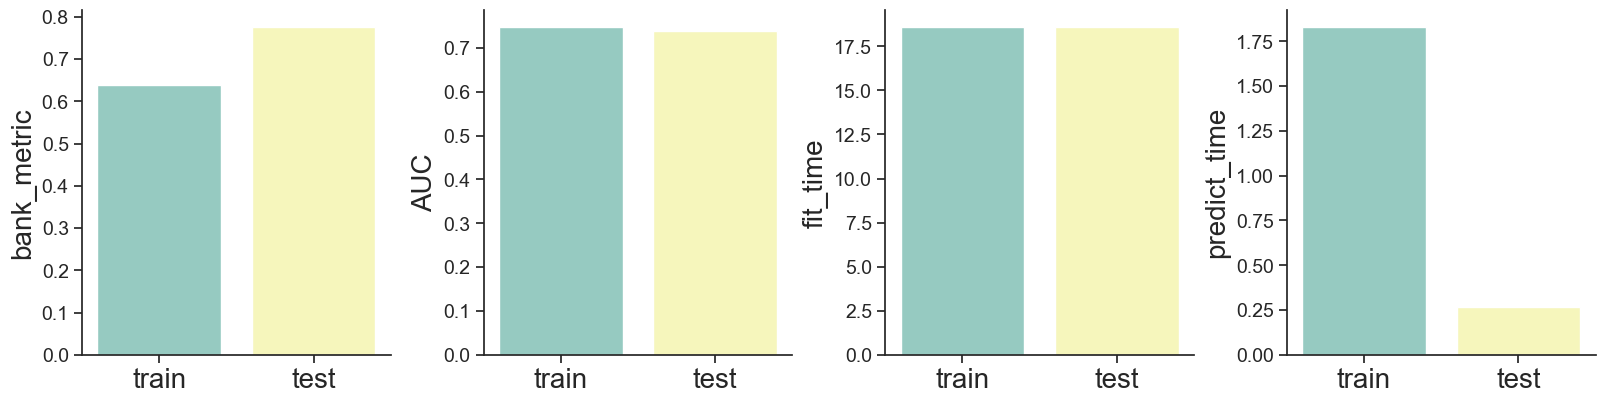

DummyClassifier


2023/11/24 16:44:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:44:27 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:44:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:44:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID e8c160463184426b8bcc6068dc099863. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: e8c160463184426b8bcc6068dc099863
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'constant': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 'scaler__copy': 'True', 'scaler__feature_range': '(0, 1)', 'steps': "[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())]", 'strategy': 'prior', 'verbose': 'False'}
metrics: {'fbeta_score-2_Xt-3': 0.0, 'fbeta_score_Xt': 0.0, 'training_accuracy_score': 0.5, 'training_f1_score': 0.3333333333333333, '

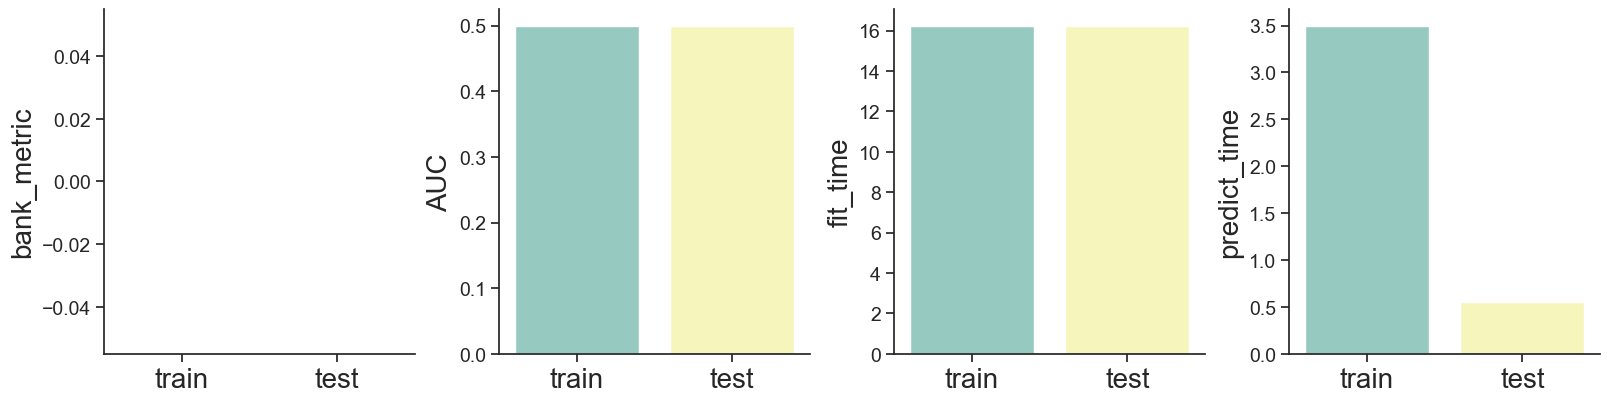

RandomForest


2023/11/24 16:44:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:44:47 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:44:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:44:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4174f06166874d7084a0a162e51387a4. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 4174f06166874d7084a0a162e51387a4
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

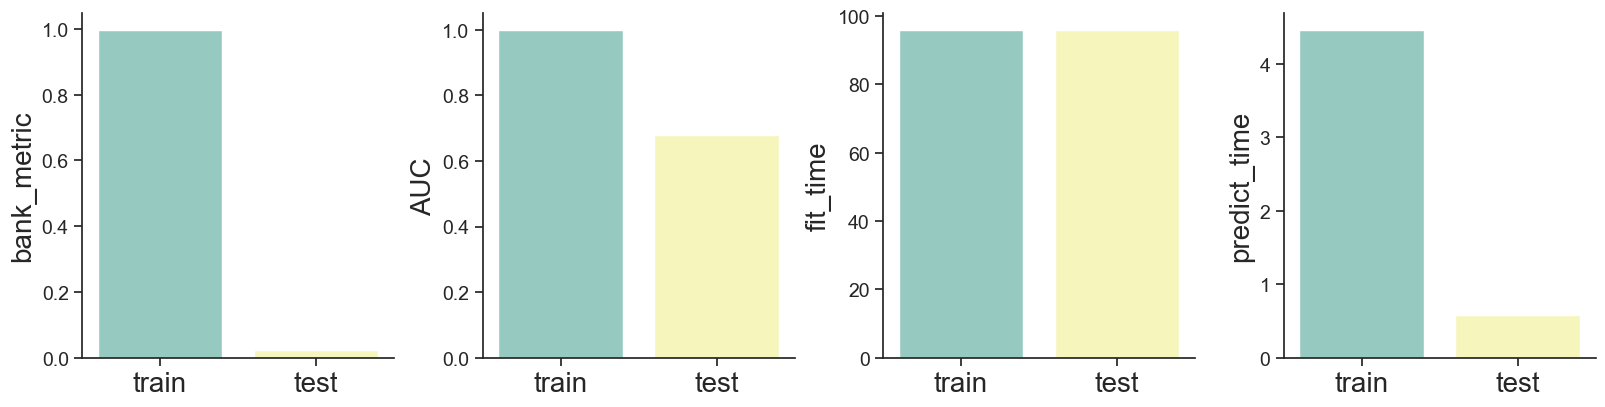

GradientBoosting


2023/11/24 16:46:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:46:29 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:46:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:46:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1e7ff03344f54ffea902dbf145fa3fdf. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 1e7ff03344f54ffea902dbf145fa3fdf
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'Fals

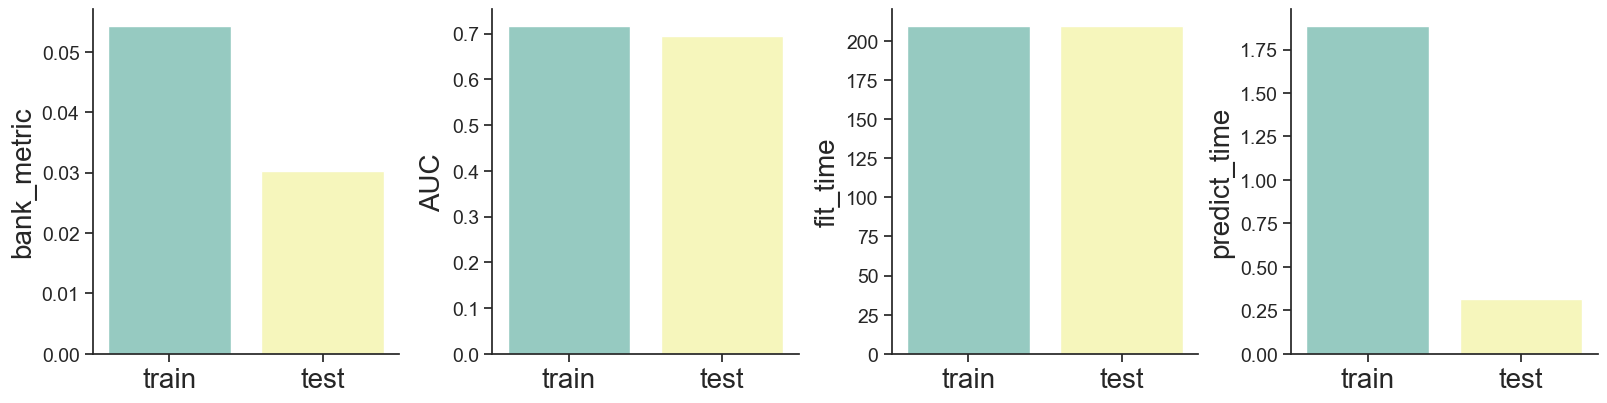

XGBClass


2023/11/24 16:49:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:50:01 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:50:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:50:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID a5b8fec8dc43479f8d7873297d87fdd1. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: a5b8fec8dc43479f8d7873297d87fdd1
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

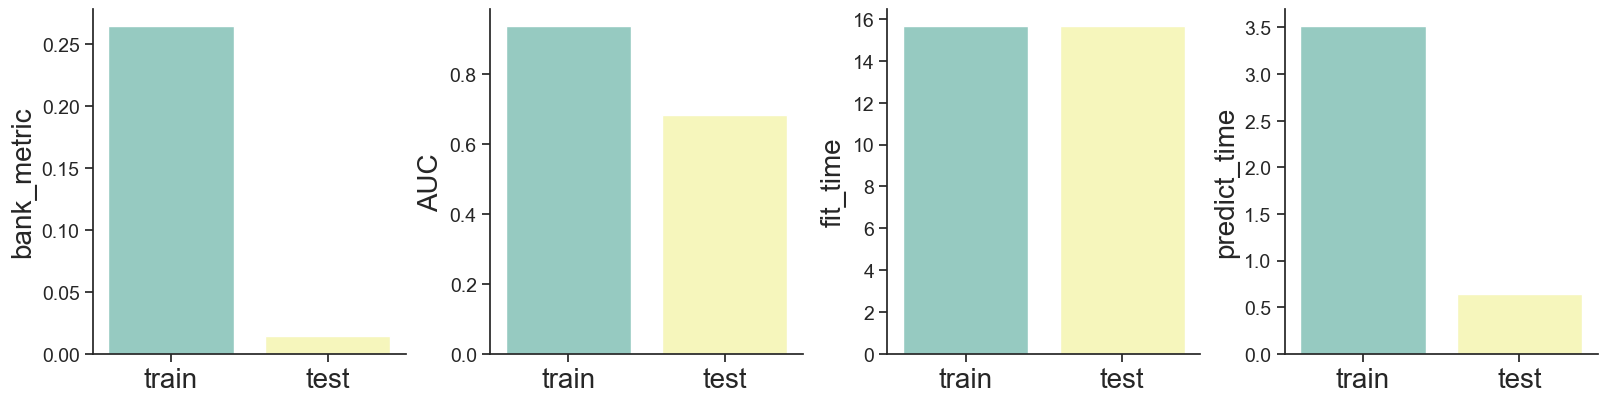

In [146]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

# Cross validation et hparams tuning avec GridsearchCV

Déterminer les meilleurs hparams des modèles. Le scoring GridCV est notre métrique métier. 
Nous évaluons ensuite les probabilités de solvabilité obtenues grâce à des métrics spécifiques (AUC, accuracy_precision_score). 

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

The beta parameter represents the ratio of recall importance to precision importance. beta > 1 gives more weight to recall, while beta < 1 favors precision. For example, beta = 2 makes recall twice as important as precision, while beta = 0.5 does the opposite. Asymptotically, beta -> +inf considers only recall, and beta -> 0 only precision.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

In [147]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the grid
param_grid_rf = {'model__n_estimators': n_estimators,
               'model__max_features': max_features}

In [148]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

learning_rate = [0.1, 0.01]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]

param_grid_gbc = {'model__learning_rate': learning_rate,
                  'model__n_estimators': n_estimators}

In [149]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

learning_rate = [0.1, 0.01]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]

param_grid_xgb = {'model__learning_rate': learning_rate,
                  'model__n_estimators' : n_estimators}


In [150]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def cv_gridsearch_control(model, param_grid):
    
    with mlflow.start_run() as run:
        # evaluate pipeline
        cv = StratifiedKFold(n_splits=5)
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=roc_auc_score)
        grid.fit(X_train, y_train)
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    # Get the results
    best_score = grid.best_score_
    print("best_score=", best_score)
    best_params = grid.best_params_
    print("best_params=", best_params)

In [151]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def cv_gridsearch_bank(model, param_grid):
    
    with mlflow.start_run() as run:
        # evaluate pipeline
        cv = StratifiedKFold(n_splits=5)
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=bank_score)
        grid.fit(X_train, y_train)
    
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    # Get the results
    best_score = grid.best_score_
    print("best_score=", best_score)
    best_params = grid.best_params_
    print("best_params=", best_params)

In [152]:
#cv_gridsearch_bank(RandomForest, param_grid_rf)
#{'model__max_features': 'sqrt', 'model__n_estimators': 50}

In [153]:
#cv_gridsearch_bank(GradientBoosting, param_grid_gbc)
# {'model__learning_rate': 0.01, 'model__n_estimators': 50}

In [154]:
#cv_gridsearch_bank(XGBClass, param_grid_xgb)
#{'model__learning_rate': 0.01, 'model__n_estimators': 50}

# Retrained our tuned models

In [155]:
import xgboost 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

steps6 = [('preprocessor', preprocessor), ('over', SMOTE()), 
          ('model', RandomForestClassifier(max_features="sqrt", n_estimators=50, random_state=1))]
RandomForest_tuned = Pipeline(steps=steps6)

steps7 = [('preprocessor', preprocessor), ('over', SMOTE()), 
          ('model',  GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 50, random_state=1))]
GradientBoosting_tuned = Pipeline(steps=steps7)

steps8 = [('preprocessor', preprocessor), ('over', SMOTE()), 
          ('model', XGBClassifier(learning_rate= 0.1, n_estimators= 50, random_state=1))]
XGBClass_tuned = Pipeline(steps=steps8)

In [156]:
dict_of_tuned_models = {"RandomForest_tuned" : RandomForest_tuned,
                  "GradientBoosting_tuned" : GradientBoosting_tuned,
                  "XGBClass_tuned" : XGBClass_tuned}

RandomForest_tuned


2023/11/24 16:50:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:50:21 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:50:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:50:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID e3276a7e1c724ddbbc8d64ec02b9b67d. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: e3276a7e1c724ddbbc8d64ec02b9b67d
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 

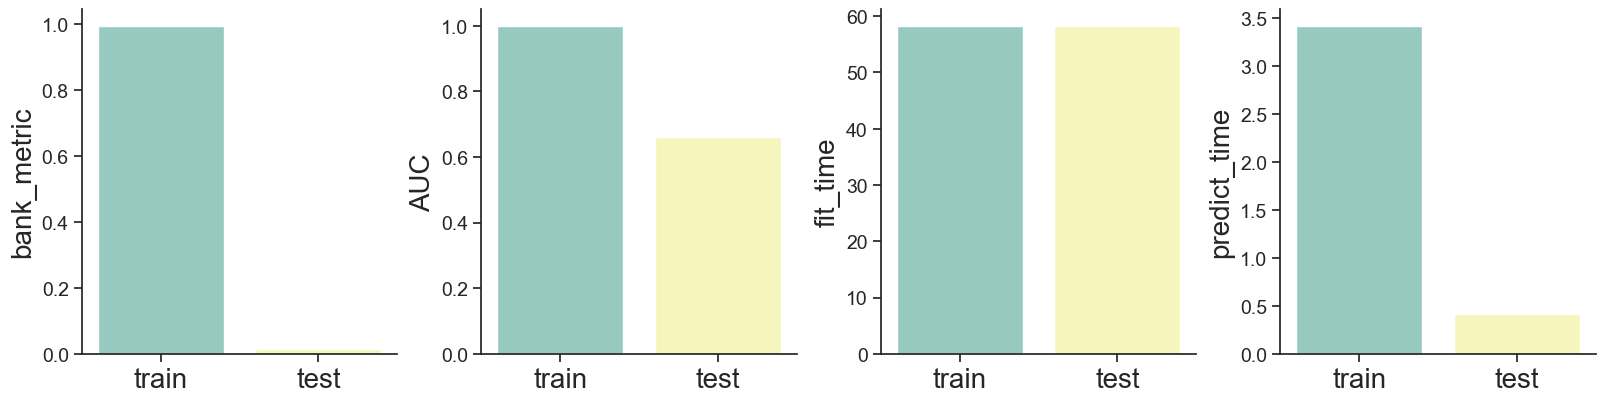

GradientBoosting_tuned


2023/11/24 16:51:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:51:24 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:51:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:51:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID a22ee516ba7940378b57bd798a57e61e. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: a22ee516ba7940378b57bd798a57e61e
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

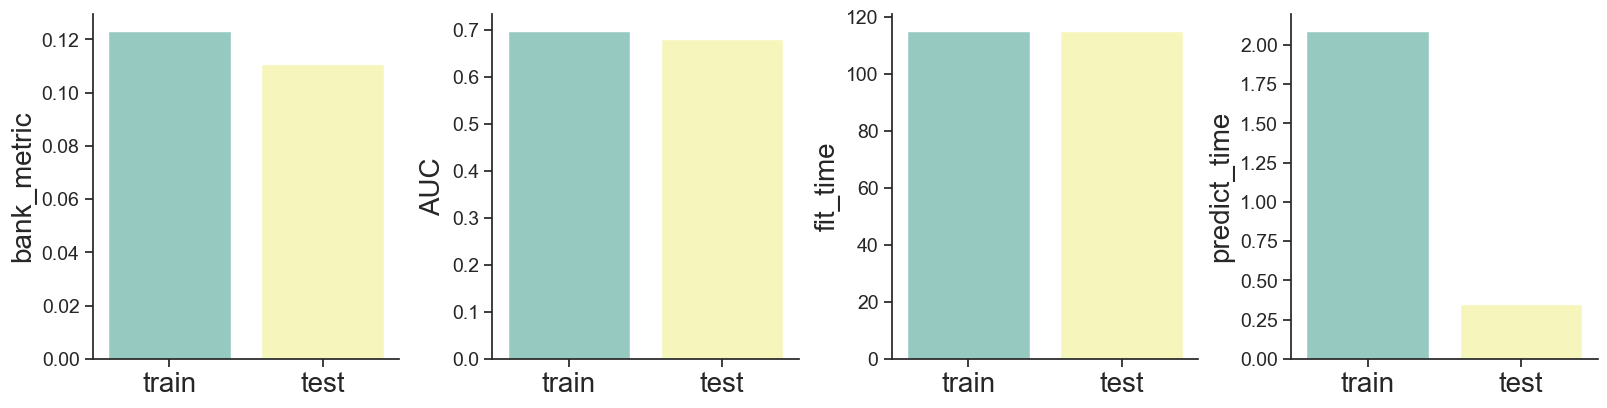

XGBClass_tuned


2023/11/24 16:53:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:53:22 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:53:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:53:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d9feab15cd88441baddd88463e003037. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: d9feab15cd88441baddd88463e003037
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowski

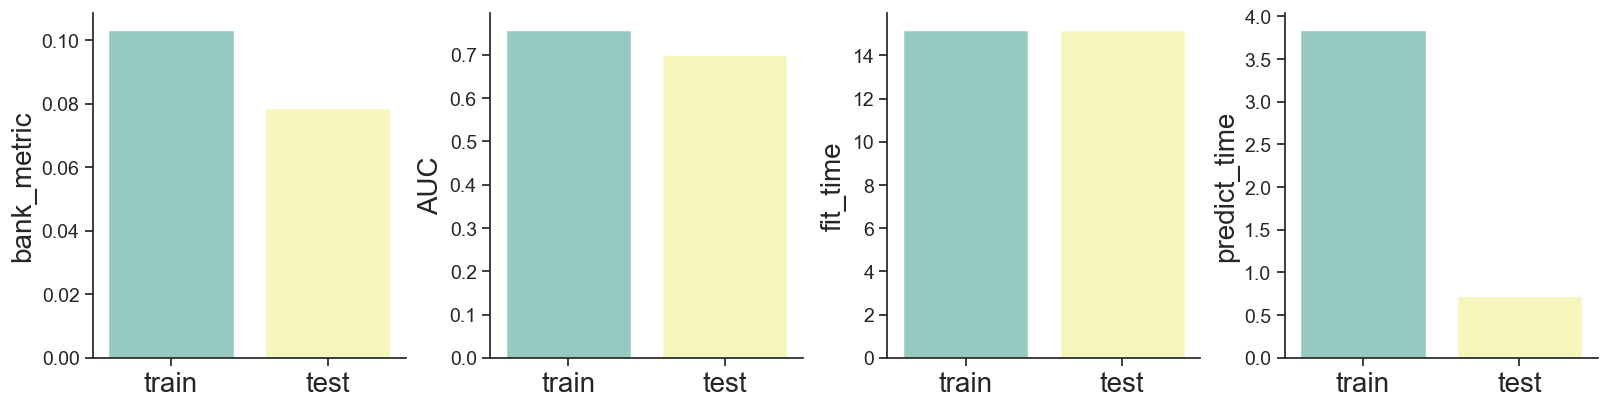

In [157]:
for name, model in dict_of_tuned_models.items():
    print(name)
    evaluation(model)

# Prediction's evaluation with a standard threshold on the tuned models

Une fois les hparams optimisé, on évalue les prédictions avec un seuil standard (e.g., 0.5)

In [158]:
def transform_treshold(df, tresh):
    
    new_df = (df >= tresh).astype("int")
    
    return new_df

In [159]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, average_precision_score

def prediction_seuil_default(model):
    
    with mlflow.start_run() as run:
        model.fit(X_train, y_train)
        start_train = time()
        y_proba_train = model.predict_proba(X_train)[:, 1]
        end_train = time()
        y_proba_test = model.predict_proba(X_test)[:, 1]
        end_test = time()
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_train = pd.DataFrame()
    df_predictions_train["y_train"] = y_train 
    df_predictions_train['y_proba_train'] = y_proba_train
    y_pred_train = transform_treshold(df_predictions_train["y_proba_train"], 0.5)
    df_predictions_train['y_pred_train'] = y_pred_train
   
    # Calculate error metrics
    time_pred_train = end_train - start_train
    auc_train = roc_auc_score(y_train, y_proba_train)
    Average_precision_score_train = average_precision_score(y_train, y_proba_train)
    accuracy_train = accuracy_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    precision_train = precision_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    recall_train = recall_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    bank_train = bank_metric(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    
     #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_test = pd.DataFrame()
    df_predictions_test["y_test"] = y_test 
    df_predictions_test['y_proba_test'] = y_proba_test
    y_pred_test = transform_treshold(df_predictions_test["y_proba_test"], 0.5)
    df_predictions_test['y_pred_test'] = y_pred_test
   
    # Calculate error metrics
    time_pred_test = end_test - end_train
    auc_test = roc_auc_score(y_test, y_proba_test)
    Average_precision_score_test = average_precision_score(y_test, y_proba_test)
    accuracy_test = accuracy_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    precision_test = precision_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    recall_test = recall_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    bank_test = bank_metric(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    
    print ("time_pred = ", time_pred_train, time_pred_test)
    print ("auc = ", auc_train, auc_test)
    print ("average_precision_score = ", Average_precision_score_train, Average_precision_score_test)
    print ("accuracy = ", accuracy_train, accuracy_test)
    print("precision = ", precision_train, precision_test)
    print("recall =", recall_train, recall_test)
    print("bank_metric =", bank_train, bank_test)
    print("") 
    
    df_result = pd.DataFrame({
    "data" : ["train", "test"],
    "time_pred" : [time_pred_train, time_pred_test],
    "auc" : [auc_train, auc_test],
    "average_precision_score" : [Average_precision_score_train, Average_precision_score_test],
    "accuracy" : [accuracy_train, accuracy_test],
    "precision" : [precision_train, precision_test],
    "recall" : [recall_train, recall_test],
    "bank_metric" : [bank_train, bank_test]})
    
    metrics = ['time_pred', 'auc', 'average_precision_score', 'accuracy', 'precision', 'recall', 'bank_metric']

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig = plt.figure(figsize=(20,60))

    for i, c in enumerate(metrics,1):
        ax = fig.add_subplot(2,7,i)
        sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set3")
        plt.xticks(fontsize= 16)
        plt.yticks(fontsize= 14)
        plt.xlabel("", fontsize= 16)
        plt.ylabel(c, fontsize= 16)

    plt.tight_layout(w_pad=2, h_pad=1)
    plt.gcf().set_size_inches(16,7)
    plt.show()
    
    return df_result, df_predictions_train, df_predictions_test

RandomForest_tuned


2023/11/24 16:53:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:53:42 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:53:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:53:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 692405ca3b3b4e41aae037859a7a144e. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 692405ca3b3b4e41aae037859a7a144e
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 

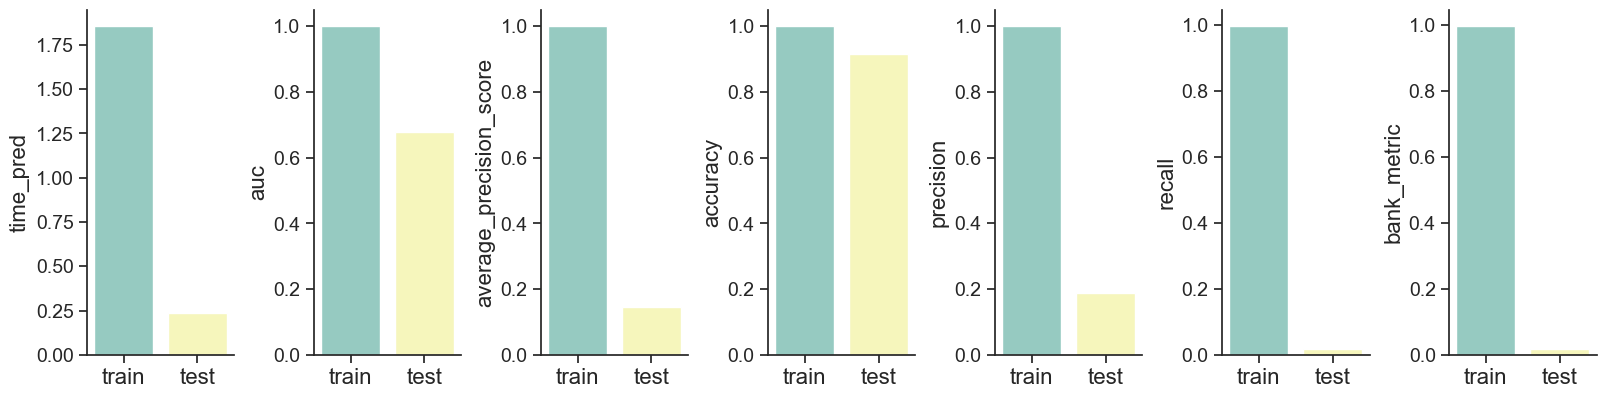

GradientBoosting_tuned


2023/11/24 16:54:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:54:46 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:54:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:54:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 31d57810113c4f098a739f0cb880d657. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 31d57810113c4f098a739f0cb880d657
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

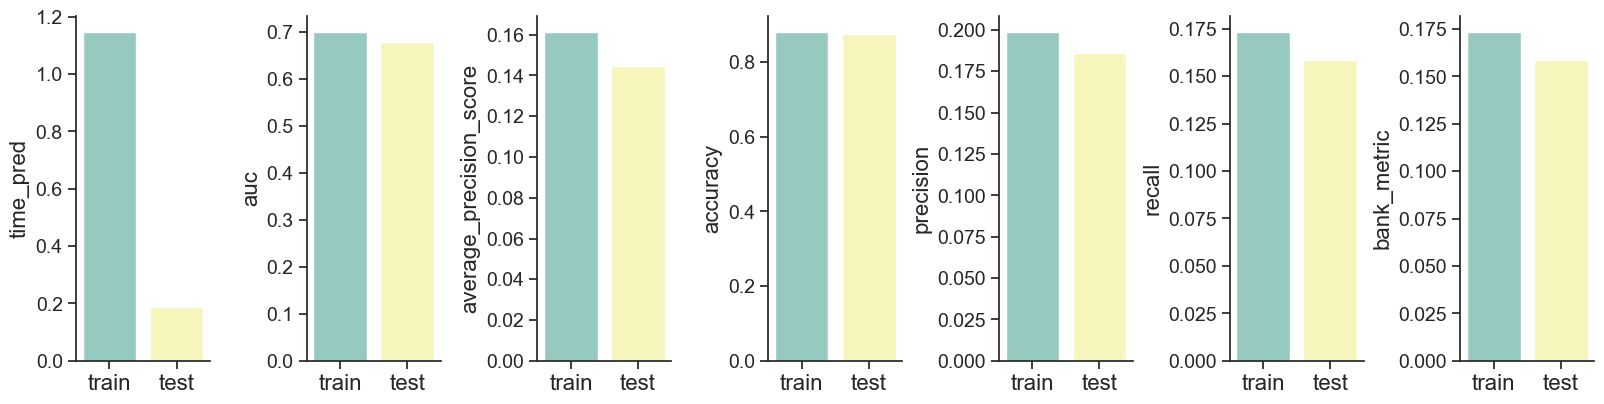

XGBClass_tuned


2023/11/24 16:56:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:56:49 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:56:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:56:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bb5a41f6d4744978bba244e7c59b6ae6. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: bb5a41f6d4744978bba244e7c59b6ae6
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowski

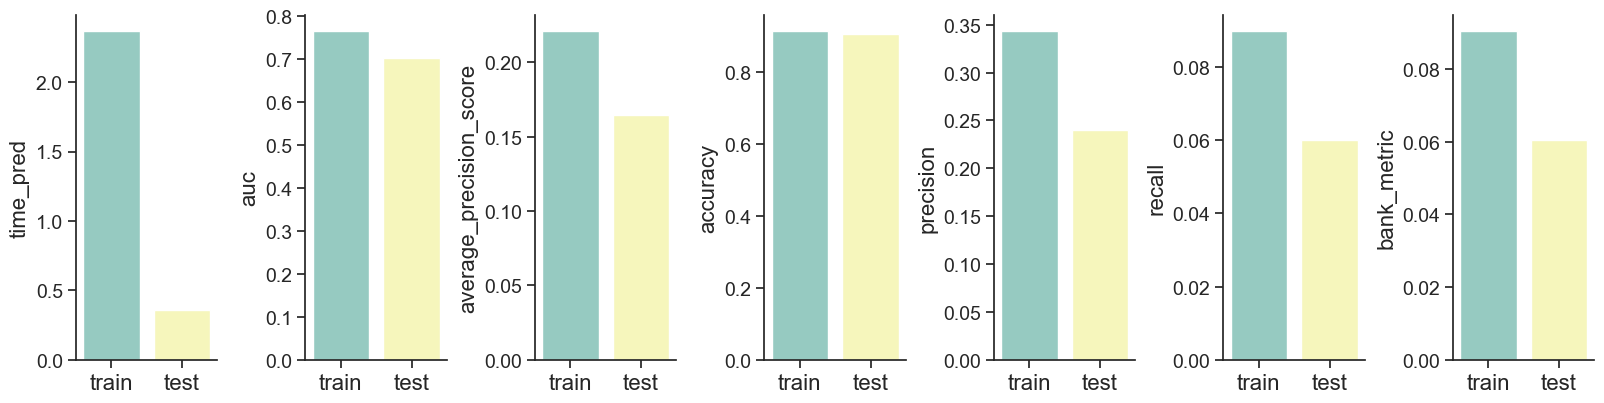

In [160]:
for name, model in dict_of_tuned_models.items():
    print(name)
    prediction_seuil_default(model)

## Search the best threshold of prediction (0.5->1) for tuned models

Déterminer le meilleur seuil technique pour les meilleurs hparams de l'étape précédente

In [161]:
from sklearn.metrics import f1_score, roc_auc_score

def seuil_solvabilité(model, X_test, y_test):
    """
    Gain en fonction du seuil de solvabilité 
    Client solvable : score < seuil  
    Client non solvable : score > seuil
    
    """
    fonction_cout = []
    #fonction_f1score = []
    #fonction_auc = []
    seuils = np.linspace(0.0, 1, 10)

    for seuil in seuils:

        with mlflow.start_run() as run:
            # Score du modèle : n = 0 ou 1
            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            # Score > seuil de solvabilité : retourne 1 sinon 0
            y_pred = (y_score > seuil)
            y_pred = np.array(y_pred > 0) * 1
        
        print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
        mlflow.end_run()

        # Calcul de l'indice bancaire
        fonction_cout.append(bank_metric(y_test, y_pred))
        #fonction_f1score.append(f1_score(y_test, y_pred))
        #fonction_auc.append(roc_auc_score(y_test, y_score))
    
    plt.figure(figsize=(5, 2.7), layout='constrained')
    plt.plot(seuils, fonction_cout, label='bank_metric')  # Plot some data on the (implicit) axes.
    #plt.plot(seuils, fonction_f1score, label='f1_score')
    #plt.plot(seuils, fonction_auc, label='roc_auc_score')
    plt.xlabel('Seuil de probabilité')
    plt.ylabel('Métriques')
    plt.legend()
    

2023/11/24 16:57:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:57:09 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:57:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:57:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 70a7aaf50d57420589e7be8a0b92b6c5. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 70a7aaf50d57420589e7be8a0b92b6c5
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 16:59:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:59:14 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 16:59:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 16:59:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID f15c7ada97d24fa39549b87931e758da. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: f15c7ada97d24fa39549b87931e758da
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:01:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:01:19 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:01:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:01:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 8b1cc5be146a487b9b827aaec52501cf. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 8b1cc5be146a487b9b827aaec52501cf
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:03:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:03:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:03:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:03:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 340a6492aeb2499386005b1a45e9a44d. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 340a6492aeb2499386005b1a45e9a44d
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:05:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:05:15 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:05:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:05:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 8b03478397e343f1a74268d6bee31539. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 8b03478397e343f1a74268d6bee31539
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:07:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:07:22 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:07:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:07:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ff221db282644ec083292eca68696088. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: ff221db282644ec083292eca68696088
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:09:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:09:22 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:09:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:09:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c320708ba1b445fcb3a8554fb5d33577. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: c320708ba1b445fcb3a8554fb5d33577
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:11:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:11:23 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:11:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:11:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 9c7cc931e6a743c98e276d1461111566. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 9c7cc931e6a743c98e276d1461111566
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:13:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:13:20 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:13:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:13:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID dc83995e2a4a46d0a8983e2e98342227. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: dc83995e2a4a46d0a8983e2e98342227
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/11/24 17:15:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:15:17 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:15:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:15:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 41b1677a8cfc4da6b5bd2bbfe4485db8. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 41b1677a8cfc4da6b5bd2bbfe4485db8
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

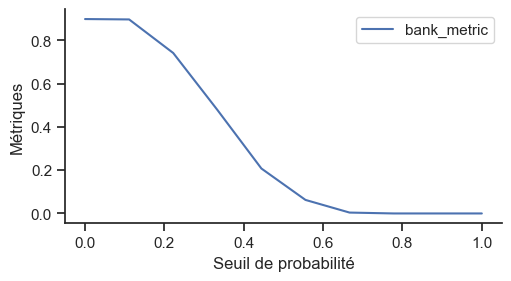

In [162]:
seuil_solvabilité(GradientBoosting_tuned, X_test, y_test)

In [163]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, average_precision_score

def prediction_seuil_optimal(model, seuil):
    
    with mlflow.start_run() as run:
        model.fit(X_train, y_train)
        start_train = time()
        y_proba_train = model.predict_proba(X_train)[:, 1]
        end_train = time()
        y_proba_test = model.predict_proba(X_test)[:, 1]
        end_test = time()
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_train = pd.DataFrame()
    df_predictions_train["y_train"] = y_train 
    df_predictions_train['y_proba_train'] = y_proba_train
    y_pred_train = transform_treshold(df_predictions_train["y_proba_train"], seuil)
    df_predictions_train['y_pred_train'] = y_pred_train
   
    # Calculate error metrics
    time_pred_train = end_train - start_train
    auc_train = roc_auc_score(y_train, y_proba_train)
    Average_precision_score_train = average_precision_score(y_train, y_proba_train)
    accuracy_train = accuracy_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    precision_train = precision_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    recall_train = recall_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    bank_train = bank_metric(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    
     #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_test = pd.DataFrame()
    df_predictions_test["y_test"] = y_test 
    df_predictions_test['y_proba_test'] = y_proba_test
    y_pred_test = transform_treshold(df_predictions_test["y_proba_test"], seuil)
    df_predictions_test['y_pred_test'] = y_pred_test
   
    # Calculate error metrics
    time_pred_test = end_test - end_train
    auc_test = roc_auc_score(y_test, y_proba_test)
    Average_precision_score_test = average_precision_score(y_test, y_proba_test)
    accuracy_test = accuracy_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    precision_test = precision_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    recall_test = recall_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    bank_test = bank_metric(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    
    print ("time_pred = ", time_pred_train, time_pred_test)
    print ("auc = ", auc_train, auc_test)
    print ("average_precision_score = ", Average_precision_score_train, Average_precision_score_test)
    print ("accuracy = ", accuracy_train, accuracy_test)
    print("precision = ", precision_train, precision_test)
    print("recall =", recall_train, recall_test)
    print("bank_metric =", bank_train, bank_test)
    print("") 
    
    df_result = pd.DataFrame({
    "data" : ["train", "test"],
    "time_pred" : [time_pred_train, time_pred_test],
    "auc" : [auc_train, auc_test],
    "average_precision_score" : [Average_precision_score_train, Average_precision_score_test],
    "accuracy" : [accuracy_train, accuracy_test],
    "precision" : [precision_train, precision_test],
    "recall" : [recall_train, recall_test],
    "bank_metric" : [bank_train, bank_test]})
    
    metrics = ['time_pred', 'auc', 'average_precision_score', 'accuracy', 'precision', 'recall', 'bank_metric']

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig = plt.figure(figsize=(20,60))

    for i, c in enumerate(metrics,1):
        ax = fig.add_subplot(2,7,i)
        sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set3")
        plt.xticks(fontsize= 16)
        plt.yticks(fontsize= 14)
        plt.xlabel("", fontsize= 16)
        plt.ylabel(c, fontsize= 16)

    plt.tight_layout(w_pad=2, h_pad=1)
    plt.gcf().set_size_inches(16,7)
    plt.show()
    
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
    cm = confusion_matrix(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
    return df_predictions_test, df_predictions_train
    

## Analyse des résultats du seuillage

2023/11/24 17:17:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:17:12 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:17:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:17:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 23b50e79885a4b4880bf7afd95ff0572. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 23b50e79885a4b4880bf7afd95ff0572
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

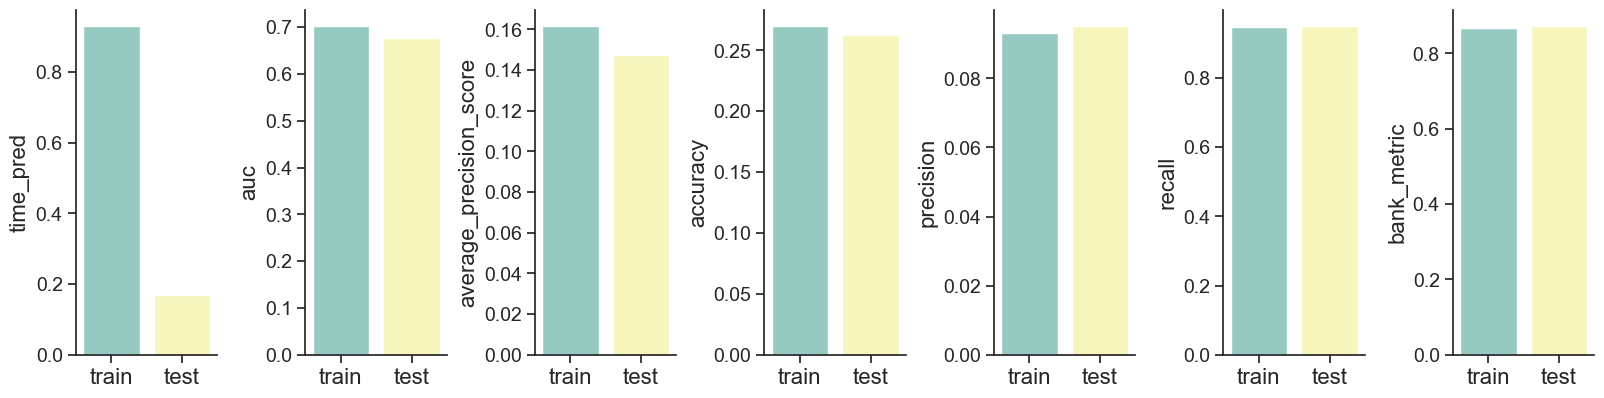

(        y_test  y_proba_test  y_pred_test
 260192       0      0.470691            1
 213180       1      0.400078            1
 13631        0      0.454451            1
 83471        0      0.317132            1
 162863       0      0.076307            0
 ...        ...           ...          ...
 71683        0      0.520666            1
 4464         0      0.163474            1
 90923        0      0.117141            0
 136066       0      0.148596            0
 295406       0      0.118688            0
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 72398         0       0.184630             1
 53000         0       0.201528             1
 252420        0       0.232131             1
 96448         0       0.170453             1
 55407         1       0.504049             1
 ...         ...            ...           ...
 167696        0       0.123768             0
 268671        0       0.218576             1
 102505        0       0.525218           

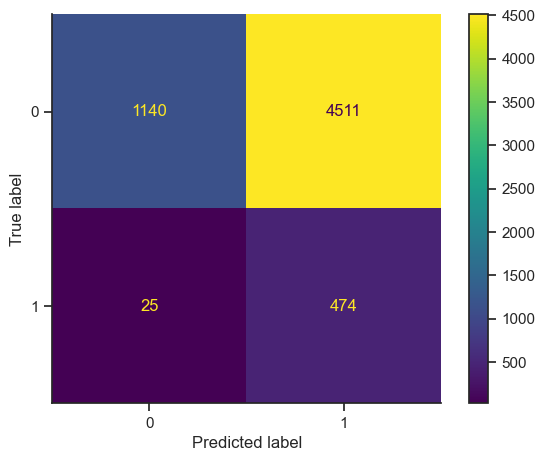

In [164]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.15)

2023/11/24 17:19:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:19:06 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:19:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:19:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 7ac8bbe819e24949bdc7066388035f81. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 7ac8bbe819e24949bdc7066388035f81
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

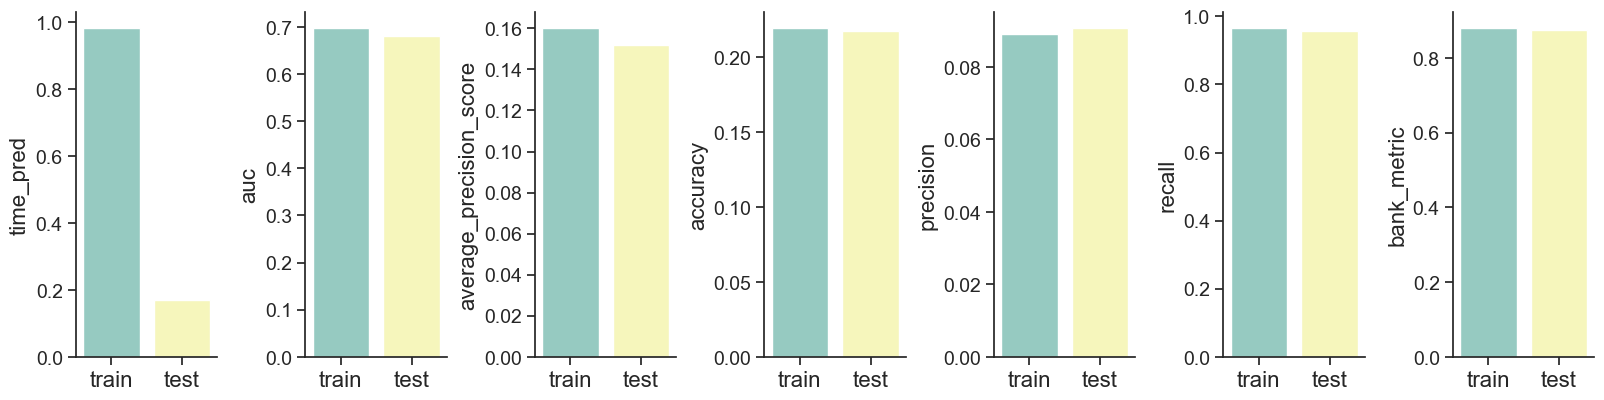

(        y_test  y_proba_test  y_pred_test
 260192       0      0.415914            1
 213180       1      0.333152            1
 13631        0      0.466073            1
 83471        0      0.288815            1
 162863       0      0.060191            0
 ...        ...           ...          ...
 71683        0      0.445602            1
 4464         0      0.156358            1
 90923        0      0.129064            0
 136066       0      0.137692            1
 295406       0      0.144411            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 72398         0       0.213212             1
 53000         0       0.210497             1
 252420        0       0.230500             1
 96448         0       0.158694             1
 55407         1       0.513339             1
 ...         ...            ...           ...
 167696        0       0.115834             0
 268671        0       0.234461             1
 102505        0       0.529500           

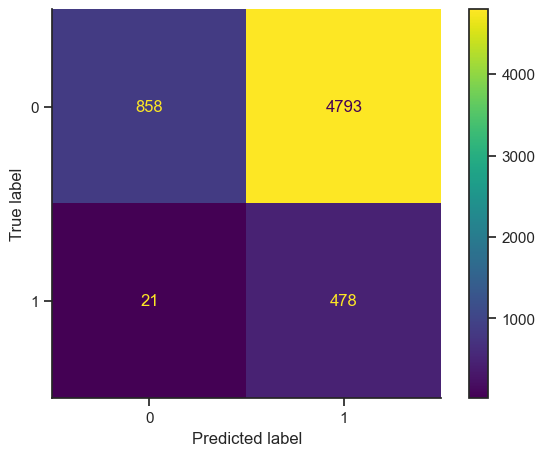

In [165]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.13)

# Modèle optimal et conclusions

Le gradient boosting Classifier donne de bons resultats, le seuillage de solvabilité a un effet direct sur les prédictions, il serait bon d'avoir plus d'information domaine. 

Nous allons maintenant nous concentrer sur le dashboard et les informations utiles à afficher pour le client.

Une fois que nous avons identifié les meilleures itérations de nos modèles, le mieux est de les entraîner sur un échantillon plus gros que précédemment. Nous allons donc relancer un preprocessing avec un échantillon plus conséquent et faire tourner nos modèles avec la meilleure itération trouvée précédemment.

In [166]:
#Model final 
import mlflow

with mlflow.start_run() as run:
    
    GradientBoosting_tuned.fit(X_train, y_train)
    y_proba = GradientBoosting_tuned.predict_proba(X_valid)[:, 1]
    df_final = pd.DataFrame()
    df_final["y_valid"] = y_valid
    df_final['y_proba'] = y_proba
    y_pred = transform_treshold(df_final["y_proba"], 0.13)
    df_final['y_pred'] = y_pred

print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
mlflow.end_run()

2023/11/24 17:20:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:21:00 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/24 17:21:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/24 17:21:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ebca2355baff4820b044a9b73e7f2dca. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: ebca2355baff4820b044a9b73e7f2dca
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

In [167]:
GradientBoosting_tuned.score(X_valid, y_valid)

0.8908943089430894

# Features importances

1. Que signifie SHAP ?
SHAP signifie SHapley Additive exPlanations et utilise l'approche de la théorie des jeux pour expliquer les prédictions des modèles.
2. Comment fonctionne la bibliothèque SHAP, Quelles sont les valeurs SHAP, Comment les valeurs SHAP sont-elles générées ?
SHAP part d'une valeur de base pour la prédiction, basée sur des connaissances préalables, puis essaie les caractéristiques des données une par une pour comprendre l'impact de l'introduction de cette caractéristique sur notre valeur de base afin d'établir la prédiction finale. Il prend même en compte l'ordre d'introduction des caractéristiques ainsi que l'interaction entre les caractéristiques, ce qui nous aide à mieux comprendre les performances du modèle. Au cours de ce processus, il enregistre les valeurs SHAP qui seront utilisées ultérieurement pour tracer et expliquer les prédictions.
Ces valeurs SHAP sont générées pour chaque caractéristique des données et montrent généralement leur impact sur la prédiction. SHAP possède de nombreux objets explicatifs qui utilisent différentes approches pour générer des valeurs SHAP en fonction de l'algorithme utilisé. Nous les avons énumérés plus loin en donnant quelques explications à leur sujet.
3. Comment interpréter les prédictions à l'aide de SHAP ?
Charger la bibliothèque shap (l'importer et l'initialiser).
Créer un objet Explainer.
Générer des valeurs SHAP pour les exemples de données en utilisant l'objet explainer.
Créer diverses visualisations à l'aide de ces valeurs shap pour expliquer les prédictions.

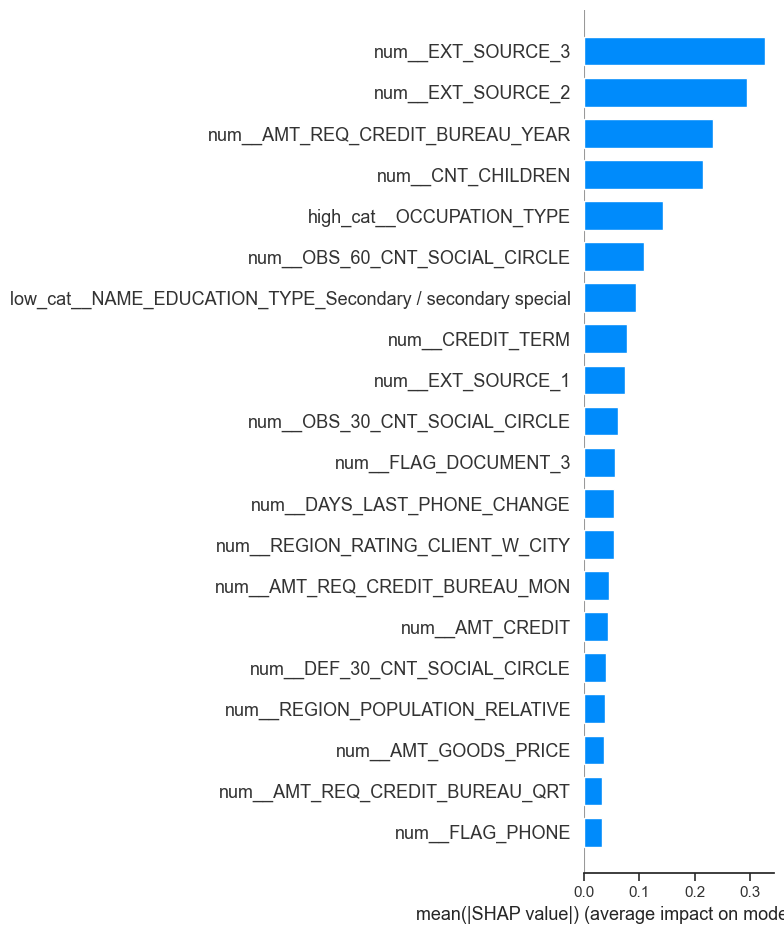

In [168]:
import shap
from shap import TreeExplainer
#set_config(transform_output="pandas")
#load JS vis in the notebook

shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(GradientBoosting_tuned['model'])

#apply the preprocessing to x_test
observations = GradientBoosting_tuned['preprocessor'].transform(X_test)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations, plot_type="bar")
#shap.plots.bar(shap_values, max_display=12)

#plot the feature importance
#shap.summary_plot(shap_values[1], observations, plot_type="bar")

Local bar plot
Passing a row of SHAP values to the bar plot function creates a local feature importance plot, where the bars are the SHAP values for each feature. Note that the feature values are show in gray to the left of the feature names.

In [169]:
random_idx = np.random.randint(len(observations))
random_idx

751

In [170]:
shap_explainer_values = explainer(observations, y_test)
type(shap_explainer_values)

shap._explanation.Explanation

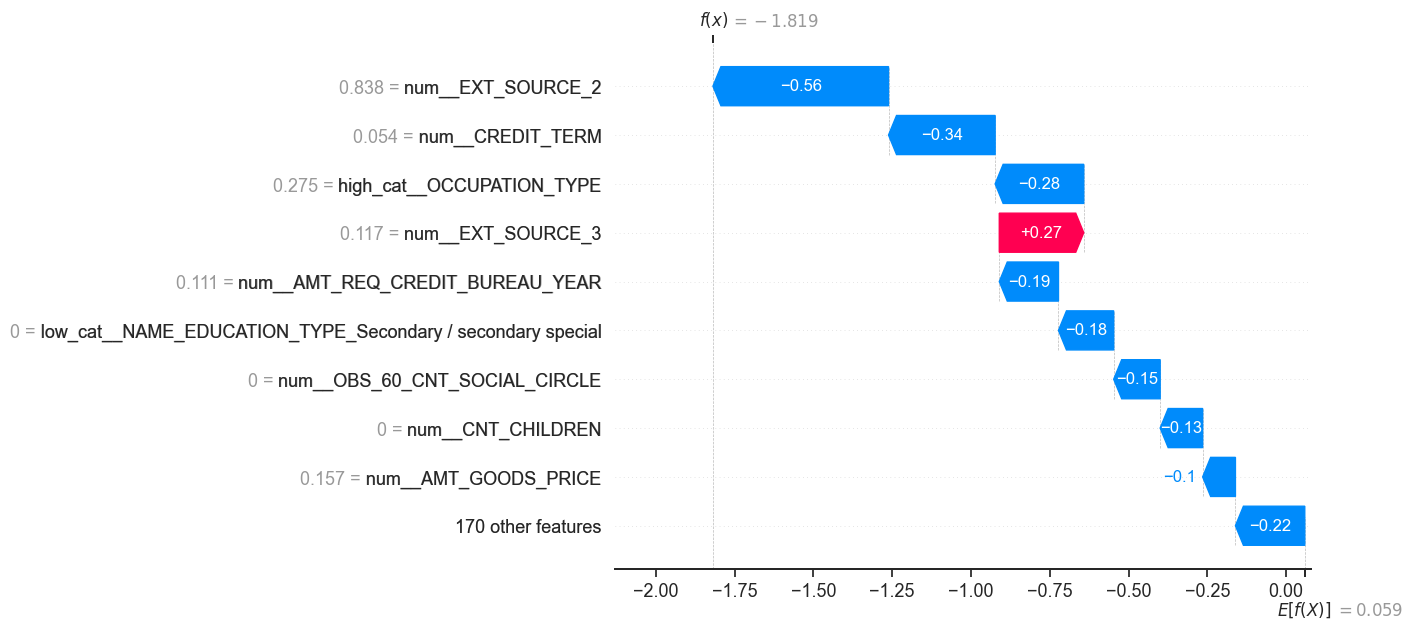

In [171]:
from shap import waterfall_plot

shap.waterfall_plot(shap_explainer_values[random_idx])

# Evaluation Data drift avec Evidently

Evidently is an open-source Python library for data scientists and ML engineers.
It helps evaluate, test, and monitor data and ML models from validation to production. It works with tabular, text data and embeddings.

In [172]:
import evidently
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [173]:
print(X_train_evidently.shape)
print(X_test_evidently.shape)
print(X_valid_evidently.shape) 

print(y_train_evidently.shape) 
print(y_test_evidently.shape)
print(y_valid_evidently.shape) 

(49201, 127)
(6150, 127)
(6150, 127)
(49201,)
(6150,)
(6150,)


In [174]:
# #Run a test suite, Split the toy data into two batches and compare them:
# #shuffle
# data_stability= TestSuite(tests=[
#     DataStabilityTestPreset(),
# ])
# data_stability.run(current_data=X_test_evidently.iloc[:60], reference_data=X_train_evidently.iloc[60:], column_mapping=None)
# data_stability.save_html("data_stability.html")
# # lien = file:///C:/Users/camil/Documents/Projet7/data_stability_test.html

In [175]:
#Get a report, Get a visual report to explore the feature distribution drift in detail:

data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=X_test_evidently.sample(frac = 0.1), reference_data=X_train_evidently.sample(frac = 0.1), column_mapping=None)
data_drift_report.save_html("data_drift_report.html")
# lien = file:///C:/Users/camil/Documents/Projet7/data_drift_report_train.html

In [185]:
pip freeze > requirements.txt 

Note: you may need to restart the kernel to use updated packages.


# Déploiement du modèle avec Mlfow ou Flask

In [176]:
# http://127.0.0.1:5000

In [177]:
#import joblib
#joblib.dump(GradientBoosting_tuned, 'GradientBoosting_bank_scoring.joblib')

In [178]:
# def best_model(X_valid):

#     steps7 = [('preprocessor', preprocessor), ('over', SMOTE()), 
#           ('model',  GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 50, random_state=1))]
#     GradientBoosting_tuned = Pipeline(steps=steps7)
#     GradientBoosting_tuned.fit(X_train, y_train)
#     y_proba = GradientBoosting_tuned.predict_proba(X_valid)[:, 1]
#     df_final = pd.DataFrame()
#     df_final['y_proba'] = y_proba
    
#     def transform_treshold(df, tresh):
#         new_df = (df >= tresh).astype("int")
#         return new_df
    
#     y_pred = transform_treshold(df_final["y_proba"], 0.13)
#     df_final['y_pred'] = y_pred
#     return df_final['y_pred']

In [179]:
# import mlflow

# model = mlflow.pyfunc.load_model("runs:/0a130dd1f0fa4ae7a84b625e06037ac4/model")
# signature = model._model_meta._signature
# signature

In [180]:
# from mlflow.models.signature import infer_signature

# signature = infer_signature(X_train, y_train)

In [181]:
# import mlflow.sklearn
# mlflow.sklearn.save_model(GradientBoosting_tuned, 'GradientBoosting_bank_test', signature = signature)

In [182]:
# Terminal:
# mlflow models serve -m GradientBoosting_bank_test/
# curl http://127.0.0.1:5000/invocations -H 'Content-Type: application/json' -d '{"data": [[1, 2, 3, 4, 5, 6, 7, 8]]}'

In [183]:
# Terminal
# streamlit run app.py
